<a href="https://colab.research.google.com/github/AjayKonathala/best-repo-ever/blob/master/TSNEMyAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

cwd= os.getcwd() #to get the current working directory location
print (cwd)



/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Colab Notebooks/Reviews.csv"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
'/content/drive/My Drive/Colab Notebooks/Reviews.csv'


In [3]:
con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Reviews.csv') 
# filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
df_bonus = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Reviews.csv',nrows=2000)
print(df_bonus)


filtered_data = df_bonus[df_bonus['Score']!=3]

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

# changing reviews with score less than 3 to be negative and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

        Id  ...                                               Text
0        1  ...  I have bought several of the Vitality canned d...
1        2  ...  Product arrived labeled as Jumbo Salted Peanut...
2        3  ...  This is a confection that has been around a fe...
3        4  ...  If you are looking for the secret ingredient i...
4        5  ...  Great taffy at a great price.  There was a wid...
...    ...  ...                                                ...
1995  1996  ...  I have to laugh at the reviews that said it wa...
1996  1997  ...  I had read some favorable reviews of this panc...
1997  1998  ...  I was expecting great things based on the revi...
1998  1999  ...  I love this pancake mix.  I bought my first ca...
1999  2000  ...  What can i say??  They are wonderful, and the ...

[2000 rows x 10 columns]
Number of data points in our data (1838, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
print(filtered_data.shape)
filtered_data.head(5)

(1838, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data[filtered_data['UserId']=='ABXLMWJIXXAIN']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# **Exploratory Data Analysis**

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(1836, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.8911860718172

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(1836, 10)


positive    1555
negative     281
Name: Score, dtype: int64

# **Text Preprocessing**

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_500 = final['Text'].values[500]
print(sent_500)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1300 = final['Text'].values[1300]
print(sent_1300)
print("="*50)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
The Milka Naps Mix Gift Box is a fun, unique gift for those tired of Whitman's and the usual American brands. Nothing wrong with Whitman's, but sometimes a change of look and flavor is nice.<br /><br />As a sampler, it provides only a few of the Milka options. Four flavors are here: noisette, hazelnuts, alpine milk and strawberry. All are delicious, though I don't like strawberry/chocolate (in any candy) personally, and give those away to eager friends. The Naps box are perfect for coffee tables and as a standalone dish at work.<br /><br />Milka and its famous purple cow, is owned by Kraft, is an eastern European chocolate originally produced in Switzerland and is available in Germany, Austria, Hungary and other nearby countries.<br /><br />Distribution is still weak in the United States, but can be found increasingly i

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_500 = re.sub(r"http\S+", "", sent_500)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_1300 = re.sub(r"http\S+", "", sent_1300)

print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1300, 'lxml')
text = soup.get_text()
print(text)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
The Milka Naps Mix Gift Box is a fun, unique gift for those tired of Whitman's and the usual American brands. Nothing wrong with Whitman's, but sometimes a change of look and flavor is nice.As a sampler, it provides only a few of the Milka options. Four flavors are here: noisette, hazelnuts, alpine milk and strawberry. All are delicious, though I don't like strawberry/chocolate (in any candy) personally, and give those away to eager friends. The Naps box are perfect for coffee tables and as a standalone dish at work.Milka and its famous purple cow, is owned by Kraft, is an eastern European chocolate originally produced in Switzerland and is available in Germany, Austria, Hungary and other nearby countries.Distribution is still weak in the United States, but can be found increasingly in larger cities. Usually, then, it i

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_500 = decontracted(sent_500)
print(sent_500)
print("="*50)

The Milka Naps Mix Gift Box is a fun, unique gift for those tired of Whitman is and the usual American brands. Nothing wrong with Whitman is, but sometimes a change of look and flavor is nice.<br /><br />As a sampler, it provides only a few of the Milka options. Four flavors are here: noisette, hazelnuts, alpine milk and strawberry. All are delicious, though I do not like strawberry/chocolate (in any candy) personally, and give those away to eager friends. The Naps box are perfect for coffee tables and as a standalone dish at work.<br /><br />Milka and its famous purple cow, is owned by Kraft, is an eastern European chocolate originally produced in Switzerland and is available in Germany, Austria, Hungary and other nearby countries.<br /><br />Distribution is still weak in the United States, but can be found increasingly in larger cities. Usually, then, it is found only in international grocery stores, though it pops up in eclectic grocers from time to time. It has been around 100 year

In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1000 = re.sub('[^A-Za-z0-9]+', ' ', sent_1000)
print(sent_1000)

The only complaint I have with pop chips is that I can t get all of the flavors at the stores where I live My husband and I both LOVE pop chips his favorite is the salt and pepper and mine is the sour cream and onion Pop chips are a perfect mix between a chip and a rice cake We cannot say enough good things about them 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 1836/1836 [00:00<00:00, 2587.44it/s]


In [26]:
preprocessed_reviews[1000]

'complaint pop chips not get flavors stores live husband love pop chips favorite salt pepper mine sour cream onion pop chips perfect mix chip rice cake cannot say enough good things'

# **Bag Of Words**

In [27]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aahhhs', 'abates', 'abby', 'abdominal', 'abiding', 'ability', 'able', 'aboulutely', 'absence', 'absent']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1836, 7638)
the number of unique words  7638


# **Bi-Grams and n-Grams.**

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1836, 1256)
the number of unique words including both unigrams and bigrams  1256


# **TF-IDF**

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'absolutely love', 'acid', 'across', 'actual', 'actually', 'add', 'added', 'addicted']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (1836, 1256)
the number of unique words including both unigrams and bigrams  1256


# **Word2Vec**

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [31]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('think', 0.999865710735321), ('also', 0.999857485294342), ('right', 0.9998519420623779), ('made', 0.9998500943183899), ('without', 0.9998400807380676), ('say', 0.9998354315757751), ('energy', 0.999830961227417), ('bad', 0.9998293519020081), ('products', 0.9998270273208618), ('away', 0.9998259544372559)]
[('month', 0.9993242025375366), ('soon', 0.9993131160736084), ('tasted', 0.9992968440055847), ('keep', 0.9992907643318176), ('gold', 0.9992905855178833), ('everything', 0.9992903470993042), ('protein', 0.9992811679840088), ('still', 0.9992721080780029), ('one', 0.9992687106132507), ('tried', 0.9992626905441284)]


In [32]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  1999
sample words  ['really', 'good', 'idea', 'product', 'outstanding', 'use', 'car', 'everybody', 'bought', 'made', 'two', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'easily', 'daughter', 'designed', 'printed', 'shop', 'going', 'lot', 'fun', 'everywhere', 'like', 'cats', 'crazy', 'last', 'thing', 'want', 'cat', 'food', 'hate', 'buying', 'used', 'super', 'gold', 'dust', 'chocolate', 'leaves', 'cake', 'son', 'wedding', 'using', 'lightly']


# Converting text into vectors using wAvg W2V, TFIDF-**W2V**

*** Average W2V***

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 1836/1836 [00:00<00:00, 1927.81it/s]

1836
50


# **TFIDF weighted W2v**

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 1836/1836 [00:05<00:00, 332.32it/s]


# **1. Applying TSNE using BOW Technique**

In [36]:
# As BoW and TF-IDF gives sparse matrix, and TSNE only accepts Dense matrix.so we need to convert sparse matrix to dense
#reference: https://www.kaggle.com/bamwani/tsne-on-amazon-fine-food-reviews
from sklearn.preprocessing import StandardScaler
print(final_bigram_counts.shape)
std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
print(std_data.shape)
type(std_data)
std_data=std_data.todense()
print(type(std_data))

(1836, 1256)
(1836, 1256)
<class 'numpy.matrix'>


Text(0.5, 1.0, 'TSNE for Bag of Words')

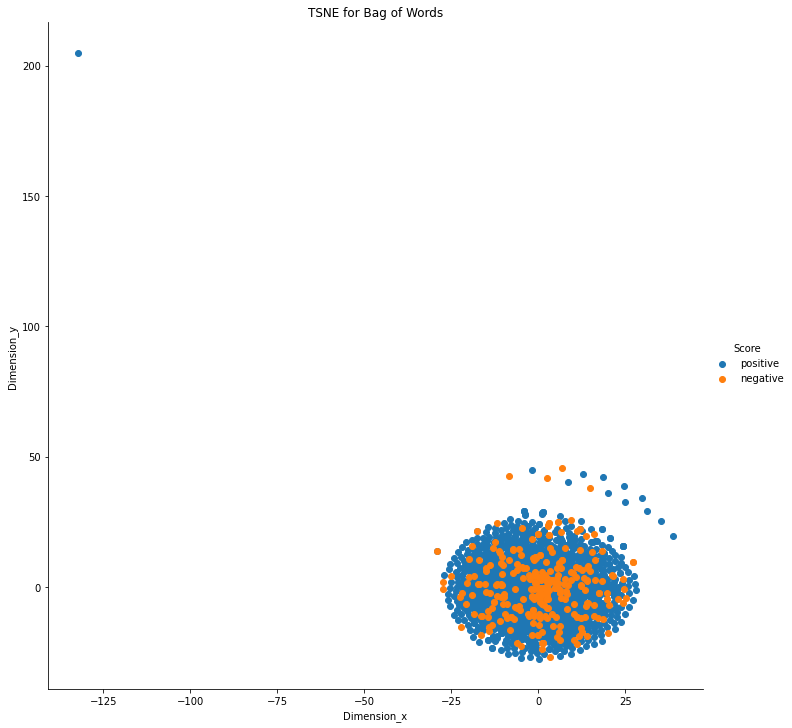

In [38]:
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

model = TSNE(n_components=2, perplexity=45, learning_rate=100, n_iter = 500, random_state=0)

for_tsne = model.fit_transform(std_data)
score = final['Score']
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=10).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TSNE for Bag of Words")

# **2. Applying TNSE on Text TFIDF vectors**

In [39]:
from sklearn.preprocessing import StandardScaler

std_data1 = StandardScaler(with_mean = False).fit_transform(final_tf_idf)
print(std_data1.shape)
type(std_data1)
std_data1=std_data1.todense()
type(std_data1)

(1836, 1256)


numpy.matrix

Text(0.5, 1.0, 'TF-IDF')

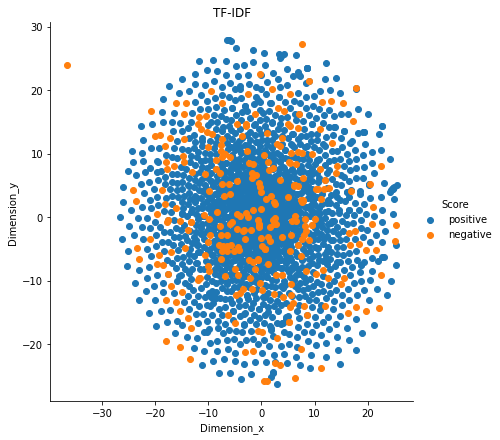

In [40]:
model = TSNE(n_components=2, perplexity=40, learning_rate=100, n_iter=500)

for_tsne = model.fit_transform(std_data1)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .toarray() will convert the sparse matrix into dense matrix
score = final['Score']
for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("TF-IDF")

# **3. Applying TNSE on Text Avg W2V vectors**

In [41]:
from sklearn.preprocessing import StandardScaler

std_data2 = StandardScaler(with_mean = False).fit_transform(sent_vectors)
print(std_data2.shape)
type(std_data2)
type(std_data2)

(1836, 50)


numpy.ndarray

Text(0.5, 1.0, 'AVG W2V')

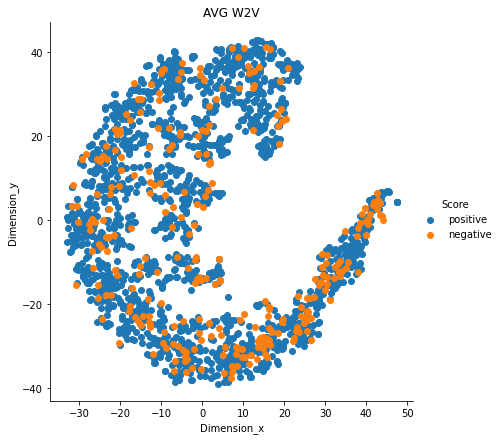

In [42]:
model = TSNE(n_components=2, perplexity=30, learning_rate=600, n_iter=500)

for_tsne = model.fit_transform(std_data2)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .todense() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("AVG W2V")

# **4.Applying TNSE on Text TFIDF weighted W2V vectors**

In [43]:
from sklearn.preprocessing import StandardScaler

std_data3 = StandardScaler(with_mean = False).fit_transform(tfidf_sent_vectors)
print(std_data3.shape)
type(std_data3)
type(std_data3)

(1836, 50)


numpy.ndarray

Text(0.5, 1.0, 'Weighted W2V')

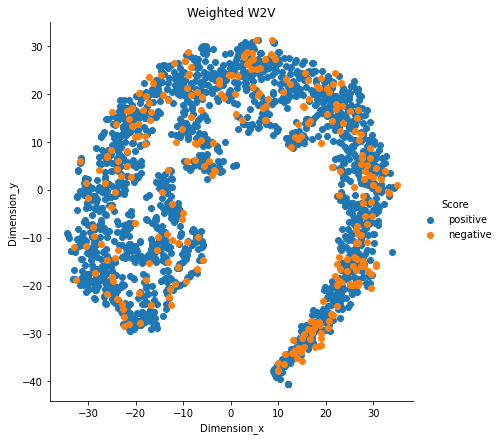

In [44]:
model = TSNE(n_components=2, perplexity=40, learning_rate=600, n_iter=500)

for_tsne = model.fit_transform(std_data3)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.todense()) , .todense() will convert the sparse matrix into dense matrix

for_tsne = np.vstack((for_tsne.T, score)).T
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
sns.FacetGrid(for_tsne_df, hue="Score", size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
plt.title("Weighted W2V")